<a href="https://colab.research.google.com/github/Frank497/NTHU_2023_DLBOI_HW/blob/main/hw2/lab3_BCE_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div align="center">

# National Tsing Hua University

### Fall 2023

#### 11210IPT 553000

#### Deep Learning in Biomedical Optical Imaging

## Lab 3: Hyperparameter Tuning

</div>


In [ ]:
# # Download dataset
#!wget https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/train/normal.npy
#!wget https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/train/pneumonia.npy


## A. Data Loading and Preprocessing

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split

import numpy as np

# Load Dataset
abnormal_scans = np.load('pneumonia.npy')
normal_scans = np.load('normal.npy')

print(f'Shape of abnormal_scans: {abnormal_scans.shape}')
print(f'Shape of normal_scans: {normal_scans.shape}')

# For the data having presence of pneumonia assign 1, for the normal ones assign 0.

abnormal_labels = np.ones((abnormal_scans.shape[0],))
normal_labels = np.zeros((normal_scans.shape[0],))

split_point = 800

x_train = np.concatenate((abnormal_scans[:split_point], normal_scans[:split_point]), axis=0)
y_train = np.concatenate((abnormal_labels[:split_point], normal_labels[:split_point]), axis=0)
x_val = np.concatenate((abnormal_scans[split_point:], normal_scans[split_point:]), axis=0)
y_val = np.concatenate((abnormal_labels[split_point:], normal_labels[split_point:]), axis=0)

# Convert to PyTorch tensors
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).long()
x_val = torch.from_numpy(x_val).float()
y_val = torch.from_numpy(y_val).long()

# Create datasets
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f'Number of samples in train and validation are {len(train_loader.dataset)} and {len(val_loader.dataset)}.')
print(f'X_train: max value is {x_train.max().item()}, min value is {x_train.min().item()}, data type is {x_train.dtype}.')

Shape of abnormal_scans: (1000, 256, 256)
Shape of normal_scans: (1000, 256, 256)
Number of samples in train and validation are 1600 and 400.
X_train: max value is 255.0, min value is 0.0, data type is torch.float32.


## B. Defining Neural Networks in PyTorch

In [ ]:
import torch.nn as nn
'''
# Model in Lab 2
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(256*256*1, 256),
    nn.Dropout(0.875),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Linear(256, 1)
).cuda()
'''
#for BCE/CE compare
model = nn.Sequential(
    nn.Flatten(),

    nn.Linear(256*256*1, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Dropout(0.5),

    nn.Linear(64, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Dropout(0.5),

    nn.Linear(64, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Dropout(0.5),

    nn.Linear(64, 1)
).cuda()

print(model)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=65536, out_features=256, bias=True)
  (2): Dropout(p=0.875, inplace=False)
  (3): ReLU()
  (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): Linear(in_features=256, out_features=1, bias=True)
)


## C. Training the Neural Network

In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

epochs = 900
best_val_loss = float('inf')

# Criterion and Optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=len(train_loader)*epochs, eta_min=0)
# lr_scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

for epoch in range(epochs):
    # Training
    model.train()
    total_loss = 0.0
    train_correct = 0
    total_train_samples = 0

    for images, labels in train_loader:
        images = images.cuda()
        images = images / 255.
        labels = labels.cuda()
        optimizer.zero_grad()
        outputs = model(images)

        labels = labels.float().unsqueeze(1)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        train_predicted = torch.sigmoid(outputs) > 0.5
        train_correct += (train_predicted.float() == labels).sum().item()
        total_train_samples += labels.size(0)

    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = 100. * train_correct / total_train_samples

    # Validation
    model.eval()
    total_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.cuda()
            images = images / 255.
            labels = labels.cuda()
            outputs = model(images)

            labels = labels.float().unsqueeze(1)

            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            predicted = torch.sigmoid(outputs) > 0.5
            correct += (predicted.float() == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = 100. * correct / total

    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

    # Learning rate update
    lr_scheduler.step()

    # Checkpoint
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'model_classification.pth')

    # Store performance
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

Epoch 1/900, Train Loss: 0.6831, Train Accuracy: 56.69%, Val Loss: 0.6692, Val Accuracy: 78.50%
Epoch 2/900, Train Loss: 0.6841, Train Accuracy: 53.56%, Val Loss: 0.6763, Val Accuracy: 76.00%
Epoch 3/900, Train Loss: 0.6741, Train Accuracy: 56.88%, Val Loss: 0.6734, Val Accuracy: 76.50%
Epoch 4/900, Train Loss: 0.6768, Train Accuracy: 56.69%, Val Loss: 0.6635, Val Accuracy: 77.50%
Epoch 5/900, Train Loss: 0.6692, Train Accuracy: 60.38%, Val Loss: 0.6582, Val Accuracy: 78.25%
Epoch 6/900, Train Loss: 0.6727, Train Accuracy: 57.69%, Val Loss: 0.6683, Val Accuracy: 75.50%
Epoch 7/900, Train Loss: 0.6726, Train Accuracy: 59.00%, Val Loss: 0.6549, Val Accuracy: 76.75%
Epoch 8/900, Train Loss: 0.6644, Train Accuracy: 61.19%, Val Loss: 0.6421, Val Accuracy: 78.50%
Epoch 9/900, Train Loss: 0.6576, Train Accuracy: 61.56%, Val Loss: 0.6370, Val Accuracy: 79.50%
Epoch 10/900, Train Loss: 0.6535, Train Accuracy: 61.12%, Val Loss: 0.6411, Val Accuracy: 78.50%
Epoch 11/900, Train Loss: 0.6676, Train

In [ ]:
#for name, param in model.named_parameters():
#    if param.requires_grad:
#        print (name, param.data)

### Visualizing model performance

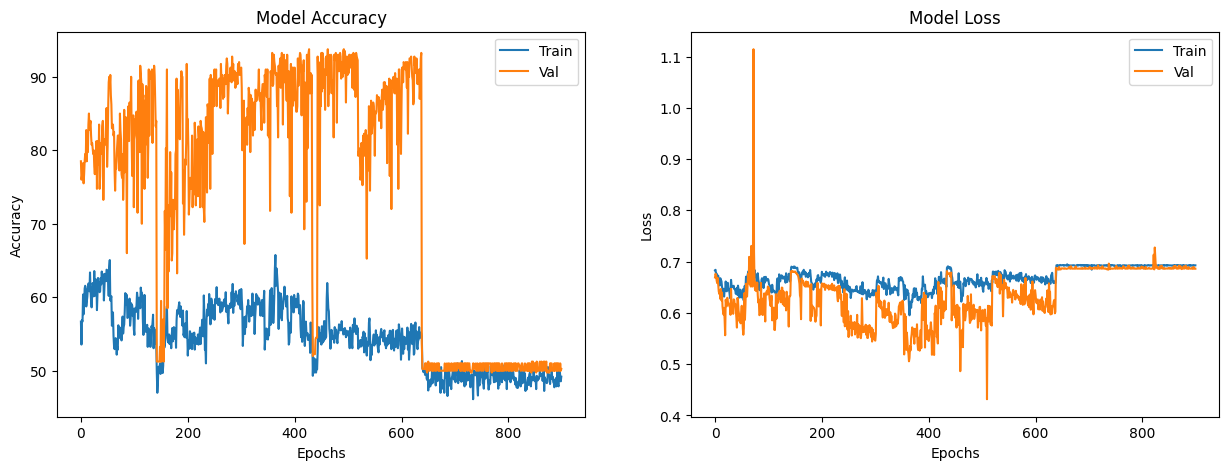

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plotting training and validation accuracy
ax[0].plot(train_accuracies)
ax[0].plot(val_accuracies)
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Val'])

# Plotting training and validation loss
ax[1].plot(train_losses)
ax[1].plot(val_losses)
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Val'])

plt.show()

In [ ]:
import csv
with open('BCE neuron model.csv', 'w') as f:

    # using csv.writer method from CSV package
    write = csv.writer(f)
    write.writerow(['train accuracies'])
    write.writerow(train_accuracies)
    write.writerow(['validation accuracy'])
    write.writerow(val_accuracies)
    write.writerow(['train loss'])
    write.writerow(train_losses)
    write.writerow(['validation loss'])
    write.writerow(val_losses)